# Sentiment analysis of movie reviews
- In this notebook, **random forest classifier** model has been trained separately on **Bag of words** features and **word embeddings** to classify sentiment of movie reviews.
- **Word2Vec** model to create **word embeddings** has been trained on sentiments using gensim library.

## Import necessary modules

In [1]:
import os
import numpy as np
import pandas as pd
from zipfile import ZipFile
import matplotlib.pyplot as plt

import nltk
import re
from bs4 import BeautifulSoup

# downloads
nltk.download('punkt')
nltk.download('stopwords')

# sentence tokenizer
from nltk.tokenize import sent_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import logging
from gensim.models import word2vec

### Mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

## Extract data from zipfile

In [3]:
# zip file path  
zip_data_path = '/content/drive/MyDrive/Movie_Reviews/reviews.zip'

# extract the contents of reviews.zip file
extract_dir = '/tmp/'

with ZipFile(zip_data_path, 'r') as zip_ref:
  zip_ref.extractall(extract_dir)

In [7]:
# construct the path of training data
train_data_path = extract_dir + 'labeledTrainData.tsv.zip'

# extract training data
with ZipFile(train_data_path, 'r') as zip_ref:
  zip_ref.extractall(extract_dir)

# list the contents of extract_dir
os.listdir(extract_dir)

['unlabeledTrainData.tsv.zip',
 'labeledTrainData.tsv',
 'labeledTrainData.tsv.zip',
 'drivefs_ipc.0_shell',
 'drivefs_ipc.0',
 'tmpelmlma9v',
 'testData.tsv.zip',
 'sampleSubmission.csv']

In [9]:
# read the training data into pandas dataframe
reviews_df = pd.read_csv(extract_dir + 'labeledTrainData.tsv', 
                         header = 0, 
                         delimiter = '\t', 
                         quoting = 3)

# display head of the dataframe
reviews_df.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


## Data exploration

In [10]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [11]:
# Check the shape of the dataset
reviews_df.shape

(25000, 3)

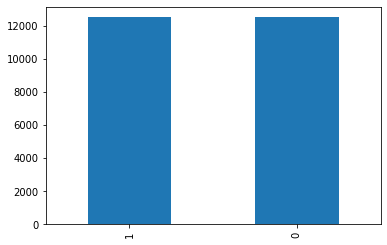

In [12]:
# Check the number of reviews in each class
reviews_df.sentiment.value_counts().plot(kind = 'bar');

In [14]:
# Check the average number of characters
print(f'Average number of characters in reviews: {np.mean(reviews_df.review.apply(len))}')

Average number of characters in reviews: 1329.71056


### Print first review from the dataset

In [22]:
reviews_df.review[0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

## Clean reviews by removing
1. Slashes
2. html tags
3. Numbers
4. Punctuations

In [37]:
# remove html tags from first review
review_1 = BeautifulSoup(reviews_df.review[0], features = 'lxml').text 
review_1

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.The actual feature film bit when it finally starts is only on for 2

In [39]:
# Tokenize the sentence
print(f'Number of sentences in first review: {len(sent_tokenize(review_1))}')

# doesn't really split all sentences
sent_tokenize(review_1)

Number of sentences in first review: 15


['"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again.',
 'Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent.',
 'Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released.',
 "Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring.",
 'Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.The actual feature film bit when it finally starts i

In [42]:
# Check if it does a better job if we add space after every period
review_1 = review_1.replace('.','. ')

print(f'Number of sentences in first review: {len(sent_tokenize(review_1))}', end = '\n\n')

Number of sentences in first review: 23



- It does solve the problem of splitting sentences

In [43]:
# print all sentences of first review
for sentence in sent_tokenize(review_1):
  print(sentence, end = '\n')

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again.
Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent.
Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released.
Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.
Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring.
Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.
The actual feature film bit when it finally starts is only on for 20 

In [44]:
# remove punctuations and all special characters from first review
review_1 = re.sub('[^a-zA-Z ]', '', review_1)
review_1

'With all this stuff going down at the moment with MJ ive started listening to his music watching the odd documentary here and there watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJs feeling towards the press and also the obvious message of drugs are bad mkay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring  Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him The actual feature film bit when it finally starts is only on for  minutes or

In [45]:
# lower case all the characters of the first review
review_1 = review_1.lower()
review_1

'with all this stuff going down at the moment with mj ive started listening to his music watching the odd documentary here and there watched the wiz and watched moonwalker again  maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  moonwalker is part biography part feature film which i remember going to see at the cinema when it was originally released  some of it has subtle messages about mjs feeling towards the press and also the obvious message of drugs are bad mkay visually impressive but of course this is all about michael jackson so unless you remotely like mj in anyway then you are going to hate this and find it boring  some may call mj an egotist for consenting to the making of this movie but mj and most of his fans would say that he made it for the fans which if true is really nice of him the actual feature film bit when it finally starts is only on for  minutes or

### Define a helper function to clean all the reviews

In [46]:
def clean_reviews(review):
  """
  Clean and preprocess a review
  1. Remove HTML tags
  2. Use regex to remove all special characters (only keep letters)
  3. Make strings to lower case and tokenize / word split reviews
  4. Remove English stopwords
  5. Rejoin to one string
  
  Args:
      review: raw review
  
  Returns:
      review: clean review
  """

  #1. Remove HTML tags
  review = BeautifulSoup(review).text
  
  #2. Use regex to find emoticons
  emotions = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', review)
  
  #3. Remove punctuation
  review = re.sub("[^a-zA-Z]", " ", review)
  
  #4. Tokenize into words (all lower case)
  review = review.lower().split()
  
  #5. Remove stopwords
  eng_stopwords = set(stopwords.words("english"))
  review = [w for w in review if not w in eng_stopwords]
  
  #6. Join the review to form one sentence
  review = ' '.join(review + emotions)

  return review

In [48]:
# store the clean reviews
review_clean_original = []

# number of reviews in the dataset
num_reviews = reviews_df.shape[0]

for i in range(num_reviews):
  if((i + 1) % 5000 == 0 ):
    # print progress
    print("Done with %d reviews" %(i + 1)) 
  review_clean_original.append(clean_reviews(reviews_df['review'][i]))

Done with 5000 reviews
Done with 10000 reviews
Done with 15000 reviews
Done with 20000 reviews
Done with 25000 reviews


## Split the data into training and validation sets

In [51]:
x_train, x_val, y_train, y_val = train_test_split(np.array(review_clean_original), 
                                                  reviews_df['sentiment'], 
                                                  test_size = 0.2, 
                                                  random_state = 42, 
                                                  stratify = reviews_df['sentiment'])

# print the shape of the training and validation datasets
print(f'x_train shape: {x_train.shape}\ny_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}\ny_val shape: {y_val.shape}')

x_train shape: (20000,)
y_train shape: (20000,)
x_val shape: (5000,)
y_val shape: (5000,)


## Bag of words approach

In [52]:
# Instantiate CountVectorizer class object
vectorizer = CountVectorizer(analyzer = "word", 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 5000)

# fit on the training data
vectorizer.fit(x_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=5000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [53]:
# print the first 10 features
vectorizer.get_feature_names()[:10]

['abandoned',
 'abc',
 'abilities',
 'ability',
 'able',
 'abraham',
 'absence',
 'absent',
 'absolute',
 'absolutely']

In [54]:
# Transform the training and validation data into a feature matrix
train_bow = vectorizer.transform(x_train) 
val_bow = vectorizer.transform(x_val)

In [57]:
print(f'train_bow shape: {train_bow.toarray().shape}')
print(f'val_bow shape: {val_bow.toarray().shape}')

train_bow shape: (20000, 5000)
val_bow shape: (5000, 5000)


## Fit random forest classifier model on bag of words features 

In [58]:
# Instantiate RandomForest Model
rf_model = RandomForestClassifier()

# Fit the model on the training data
rf_model.fit(train_bow, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Evaluate the model performance on the validation dataset

In [59]:
pred_val = rf_model.predict(val_bow)
print(f'Accuracy on validation data set: {accuracy_score(y_val, pred_val)}')

Accuracy on validation data set: 0.8406


In [60]:
# confusion matrix
confusion_matrix(y_val, pred_val)

array([[2115,  385],
       [ 412, 2088]])

In [61]:
# f1-score
f1_score(y_val, pred_val)

0.8397345666599638

## Define a function to prepare data, built and evaluate model

In [ ]:
def predict_sentiment(cleaned_reviews, y = train["sentiment"], max_features = 5000):
  """
  This function prepares bag of words features, split the data into training and validation datasets,
  fits the random forest model and evaluate its performance on the validation data
  
  Args:
      cleaned_reviews: list of processed reviews
      y: target variable (0: negative sentiment, 1: positive sentiment)
      max_features: maximum number of words in the vocabulary
      
  Returns:
      rf_model: random forest model
      vectorizer: bag of words model
  """


  print("Creating the bag of words model!\n")
  vectorizer = CountVectorizer(analyzer = "word",
                               tokenizer = None,
                               preprocessor = None,
                               stop_words = None,
                               max_features = max_features) 
    
  print("Splitting data into training and validation sets!\n")
  x_train, x_val, y_train, y_val = train_test_split(cleaned_reviews, 
                                                    y, 
                                                    random_state = 42, 
                                                    test_size = 0.2)

  # use fit_transform() to fit the model/learn the vocabulary and transform the data into feature vectors
  # input should be a list of strings. .toarraty() converts to a numpy array
  
  train_bow = vectorizer.fit_transform(x_train).toarray()
  val_bow = vectorizer.transform(x_val).toarray()

  # You can extract the vocabulary created by CountVectorizer
  # by running print(vectorizer.get_feature_names())

  print("Training the random forest classifier!\n")
  # Initialize a Random Forest classifier
  rf_model = RandomForestClassifier() 

  # Fit the random forest model to the training set, using the bag of words as 
  # features and the sentiment labels as the target variable
  rf_model.fit(train_bow, y_train)


  print("Making predictions on the validation set!\n")
  val_preds = rf_model.predict(val_bow)

  print("Calculating accuracy on the validation set!\n")
  valid_acc = accuracy_score(y_val, val_preds)
  print("The validation accuracy is: ", valid_acc)
  
  return (rf_model, vectorizer)

## Prepare Word2Vec features using gensim library 

In [63]:
%%time
# configure the built-in logging module so that Word2Vec creates nice output messages
logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s', 
                    level = logging.INFO)

sentences = [review.split() for review in review_clean_original]

# Set values for various parameters
num_features = 100    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 12          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
print("Training model...")
model = word2vec.Word2Vec(sentences, workers = num_workers, 
                          size = num_features, min_count = min_word_count,
                          window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace = True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "100features_40minwords_12context"
model.save(model_name)

2021-01-02 10:51:34,993 : INFO : 'pattern' package not found; tag filters are not available for English
2021-01-02 10:51:35,005 : INFO : collecting all words and their counts
2021-01-02 10:51:35,006 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


Training model...


2021-01-02 10:51:35,300 : INFO : PROGRESS: at sentence #10000, processed 1205390 words, keeping 51389 word types
2021-01-02 10:51:35,611 : INFO : PROGRESS: at sentence #20000, processed 2396959 words, keeping 67676 word types
2021-01-02 10:51:35,769 : INFO : collected 74082 word types from a corpus of 2988534 raw words and 25000 sentences
2021-01-02 10:51:35,770 : INFO : Loading a fresh vocabulary
2021-01-02 10:51:35,824 : INFO : effective_min_count=40 retains 8164 unique words (11% of original 74082, drops 65918)
2021-01-02 10:51:35,825 : INFO : effective_min_count=40 leaves 2627602 word corpus (87% of original 2988534, drops 360932)
2021-01-02 10:51:35,860 : INFO : deleting the raw counts dictionary of 74082 items
2021-01-02 10:51:35,868 : INFO : sample=0.001 downsamples 30 most-common words
2021-01-02 10:51:35,869 : INFO : downsampling leaves estimated 2494733 word corpus (94.9% of prior 2627602)
2021-01-02 10:51:35,900 : INFO : estimated required memory for 8164 words and 100 dimen

CPU times: user 54.8 s, sys: 449 ms, total: 55.2 s
Wall time: 30.6 s


In [65]:
# load the word embeddings
model = word2vec.Word2Vec.load("100features_40minwords_12context")

2021-01-02 10:57:32,266 : INFO : loading Word2Vec object from 100features_40minwords_12context
2021-01-02 10:57:32,345 : INFO : loading wv recursively from 100features_40minwords_12context.wv.* with mmap=None
2021-01-02 10:57:32,346 : INFO : setting ignored attribute vectors_norm to None
2021-01-02 10:57:32,348 : INFO : loading vocabulary recursively from 100features_40minwords_12context.vocabulary.* with mmap=None
2021-01-02 10:57:32,349 : INFO : loading trainables recursively from 100features_40minwords_12context.trainables.* with mmap=None
2021-01-02 10:57:32,351 : INFO : setting ignored attribute cum_table to None
2021-01-02 10:57:32,352 : INFO : loaded 100features_40minwords_12context


In [67]:
# shape of the embedding matrix
model.wv.vectors.shape

(8164, 100)

In [68]:
# Get vocabulary count of the model
vocab_tmp = list(model.wv.vocab)
print('Vocab length:', len(vocab_tmp))

# Get distributional representation of each word
X = model[vocab_tmp]

Vocab length: 8164


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


## Vector averaging to get the feature encoding of reviews

In [70]:
def makeFeatureVec(review, model):
  """
  This function returns the average of word vectors in a given review
  
  Args:
      review: a single movie review
      model: Word2Vec model

  Returns:
      featureVec: average of word vectors in a given review
  """
  # Function to average all of the word vectors in a given paragraph
  featureVec = []
  
  # Index2word is a list that contains the names of the words in 
  # the model's vocabulary. Convert it to a set, for speed 
  index2word_set = set(model.wv.index2word)
  
  # Loop over each word in the review and, if it is in the model's
  # vocaublary, add its feature vector to the total
  for n, word in enumerate(review):
    if word in index2word_set: 
      featureVec.append(model[word])
          
  # Average the word vectors for a review
  featureVec = np.mean(featureVec, axis = 0)
  return featureVec

In [ ]:
def getAvgFeatureVecs(reviews, model):
  """
  This function calculates the average feature vector for each review
  
  Args:
      reviews: list of reviews
      model: Word2Vec model
      
  Returns:
      reviewFeatureVecs: average of feature vectors for all the reviews
  """
  # Given a set of reviews (each one a list of words), calculate 
  # the average feature vector for each review
  
  reviewFeatureVecs = []
  # Loop through the reviews
  for counter, review in enumerate(reviews):
    # Print a status message every 5000th review
    if counter % 5000. == 0.:
      print("Review %d of %d" % (counter, len(reviews)))

    # Call the function (defined above) that makes average feature vectors
    vector = makeFeatureVec(review, model)
    reviewFeatureVecs.append(vector)
        
  return reviewFeatureVecs

In [73]:
def train_sentiment(cleaned_reviews, y = reviews_df["sentiment"]):
  """
  This function will:
  1. Convert reviews into feature vectors using word2vec.
  2. split data into train and validation set.
  3. train a random forest model using word embeddings and y (labels)
  4. validate the model on the validation split
  5. print accuracy of sentiment prediction on validation data
  6. print confusion matrix on validation data results
  
  Args:
      cleaned_reviews: list of processed reviews
      y: target variable (0: negative sentiment, 1: positive sentiment)
      
  Returns: None  
  """

  print("1.Creating Feature vectors using word2vec...\n")
  trainDataVecs = getAvgFeatureVecs(cleaned_reviews, model)
  
  
  print("\n2.Splitting dataset into train and test sets...\n")
  x_train, x_val, y_train, y_val = train_test_split(trainDataVecs, y, random_state = 42, test_size = 0.2)

  
  print("3. Training the random forest classifier...\n")
  # Initialize Random Forest classifier 
  rf_model = RandomForestClassifier() 

  # Fit the random forest model to the training set, using word embeddings as
  # features and the sentiment labels as the target variable
  rf_model.fit(train_bow, y_train)
  
  print("Making predictions on the validation set!\n")
  val_preds = rf_model.predict(val_bow)

  print("Calculating accuracy on the validation set!\n")
  valid_acc = accuracy_score(y_val, val_preds)
  print("The validation accuracy is: ", valid_acc)

In [74]:
train_sentiment(cleaned_reviews = review_clean_original, y = reviews_df["sentiment"])

1.Creating Feature vectors using word2vec...

Review 0 of 25000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Review 5000 of 25000
Review 10000 of 25000
Review 15000 of 25000
Review 20000 of 25000

2.Splitting dataset into train and test sets...

3. Training the random forest classifier...

The validation accuracy is:  0.505


- The validation accuracy of random forest classifier trained on word embeddings is very low. This is due to small size of dataset to train word embeddings from scratch. 